In [1]:
%load_ext line_profiler

In [2]:
from IPython.core.display import display, HTML
#display(HTML('<style>.container {width:100% !important;} <\style>'))

In [3]:
from trivariatevectorlinearinterpolation import LinearAimAssister, LinearEigenvectorInterpolator, Dp54Linear

In [4]:
from auxiliarypointstuff import cy_compute_pos_aim, cy_cross_product, \
                                cy_in_plane, cy_orthogonal_component, \
                                cy_parallel_component, cy_normalize, \
                                cy_norm2, cy_min

In [5]:
from ndcurvebsplineinterp import NDCurveBSplineInterpolator # <= Krever Fortran-Python-kobling

In [6]:
from trivariatevectorbsplineinterpolation import SplineAimAssister, SplineEigenvectorInterpolator, Dp54BSpline
# ^ Krever Fortran-Python-kobling

In [7]:
from trivariatescalarinterpolation import TrivariateSpline
# ^ Krever Fortan-Python-kobling

In [8]:
import sys
sys.path.insert(0,'../..') # Sett inn det som trengs for at numerical_integrators
                           # blir tilgjengelig i path

In [9]:
from numerical_integrators.singlestep import rk2, rk3, rk4
from numerical_integrators.adaptive_step import rkdp54,rkdp87

In [10]:
import multiprocessing as mp
import numpy as np
from numba import njit
import math
import time

In [12]:
import matplotlib as mpl
mpl.use("pgf")

#################################################
##### Fjern kommentarer for bonus-stilpoeng #####
#################################################

# Custom matplotlib config (fonts etc)

## TeX preamble
#pgf_with_pdflatex = {
#    "font.family": "serif",
#    "text.usetex": True,
#    "text.latex.unicode": True,
#    "pgf.texsystem": "pdflatex",
#    "pgf.preamble": [
#         r"\usepackage[utf8x]{inputenc}",
#         r"\usepackage[T1]{fontenc}",
#         r"\usepackage[]{libertine}"
#         r"\usepackage[libertine]{newtxmath}"
#         ]
#}
#mpl.rcParams.update(pgf_with_pdflatex)


#mpl.rcParams['font.family'] = 'Libertine'

#from matplotlib import rc
#rc('font', **{'family': 'serif', 'serif': ['Linux Libertine']})

#import matplotlib.font_manager as fm
#prop = fm.FontProperties(fname='/usr/local/texlive/2017/texmf-dist/fonts/opentype/public/libertine/LinLibertine_DR.otf')

from matplotlib import pyplot as plt
#plt.rc('text',usetex=True)
plt.rc('figure',figsize=(5.05,3.1),dpi=100)
#plt.rc('text.latex',preamble=[r'\usepackage[]{libertine}',r'\usepackage[libertine]{newtxmath}'])
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [13]:
def f(t,x,A=np.sqrt(3),B=np.sqrt(2),C=1):
    """ A function which computes the right hand side(s) of the coupled equation of variations
    for the flow map Jacobian, for steady ABC flow.
    
    param: t -- Time
    param: x -- Twelve-component (NumPy) array, containing the flow map and Jacobian at time t. 
                Shape: (12,nx,ny,nz)
    OPTIONAL:
    param: A -- Default: A = sqrt(3)
    param: B -- Default: B = sqrt(2)
    param: C -- Default: C = 1
    
    return: Twelve-component array, containing the (component-wise) right hand side of the
            coupled equation of variations
            Shape: (12,nx,ny,nz)
    """
    ret = np.empty(x.shape)
    ret[0] = A*np.sin(x[2]) + C*np.cos(x[1])                # x-component of velocity field
    ret[1] = B*np.sin(x[0]) + A*np.cos(x[2])                # y-component of velocity field
    ret[2] = C*np.sin(x[1]) + B*np.cos(x[0])                # z-component of velocity field
    ret[3] = -C*np.sin(x[1])*x[6] + A*np.cos(x[2])*x[9]     # The remaining (coupled) entries 
    ret[4] = -C*np.sin(x[1])*x[7] + A*np.cos(x[2])*x[10]    # constitute the RHS of the 
    ret[5] = -C*np.sin(x[1])*x[8] + A*np.cos(x[2])*x[11]    # variational ODE for the 
    ret[6] = B*np.cos(x[0])*x[3] + -A*np.sin(x[2])*x[9]     # flow map Jacobian
    ret[7] = B*np.cos(x[0])*x[4] + -A*np.sin(x[2])*x[10]
    ret[8] = B*np.cos(x[0])*x[5] + -A*np.sin(x[2])*x[11]
    ret[9] = -B*np.sin(x[0])*x[3] + C*np.cos(x[1])*x[6]
    ret[10] = -B*np.sin(x[0])*x[4] + C*np.cos(x[1])*x[7]
    ret[11] = -B*np.sin(x[0])*x[5] + C*np.cos(x[1])*x[8]
    return ret

def compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,func,integ,nproc=4):
    """A function which computes the eigenvalues and -vectors for the Cauchy-Green 
    strain tensor for a given velocity field in a given time interval, on a 
    regular Cartesian grid.
    
    param: t0 -- Start time
    param: x  -- (NumPy) array of abscissae values along the x-axis, i.e., 
                 the x-values of the points in the computational grid.
    param: y  -- (NumPy) array of abscissae values along the y-axis, i.e., 
                 the y-values of the points in the computational grid.
    param: z  -- (NumPy) array of abscissae values along the z-axis, i.e., 
                 the z-values of the points in the computational grid.
    param: tf -- End time
    param: h  -- (Initial) integration time step
    param: func -- Function handle, pointing to function returning the RHS
                   of the flow ODE system
    param: integ -- Function handle, pointing to function which performs
                    numerical integration (e.g., a Runge-Kutta solver)
    OPTIONAL:
    param: nproc -- The number of available cores for multiprocessing. 
                    Default: nproc=4
    
    return: lambdas -- 3-tuple of computed strain eigenvalues.
                       Sorted in ascending order. 
    return: xis     -- 3-tuple of computed (normalized) strain
                       eigenvectors. Sorted in the same order
                       as the eigenvalues.
    """
    jac = find_endpoint_jacobian(t0,x,y,z,tf,h,func,integ,nproc)
    u, s, v = np.linalg.svd(jac)
    
    lm1 = s[...,2]**2
    lm2 = s[...,1]**2
    lm3 = s[...,0]**2
    
    xi1 = v[...,2]
    xi2 = v[...,1]
    xi3 = v[...,0]
    
    return (np.ascontiguousarray(lm1), np.ascontiguousarray(lm2), np.ascontiguousarray(lm3)), \
            (np.ascontiguousarray(xi1), np.ascontiguousarray(xi2), np.ascontiguousarray(xi3))
    
def find_endpoint_jacobian(t0,x,y,z,tf,h,func,integ,nproc):
    """A function which computes the final state of the flow map Jacobian for three-dimensional
    tracer advection.
    
    param: t0 -- Start time
    param: x  -- (NumPy) array of abscissae values along the x-axis, i.e., 
                 the x-values of the points in the computational grid.
    param: y  -- (NumPy) array of abscissae values along the y-axis, i.e., 
                 the y-values of the points in the computational grid.
    param: z  -- (NumPy) array of abscissae values along the z-axis, i.e., 
                 the z-values of the points in the computational grid.
    param: tf -- End time
    param: h  -- (Initial) integration time step
    param: func -- Function handle, pointing to function returning the RHS
                   of the flow ODE system
    param: integ -- Function handle, pointing to function which performs
                    numerical integration (e.g., a Runge-Kutta solver)
    param: nproc -- The number of available cores for multiprocessing. 
    
    return: jac -- (NumPy) array of final state Jacobian values, with shape
                   (nx,ny,nz,3,3)
    """
                                                                     
    grid = np.zeros((12,x.shape[0],y.shape[0],z.shape[0]))
    grid[:3] = np.array(np.meshgrid(x,y,z,indexing='ij'))    # Initial conditions (to be advected)
    grid[3]  = 1                                             # Initial condition for the flow map Jacobian: 
    grid[7]  = 1                                             #     Identity matrices
    grid[11] = 1
    
    # Divide the advection across the no. of available processor cores
    div = np.ceil(np.linspace(0,x.shape[0],nproc+1)).astype(int) 
    
    # Initialize queues and processes for multiprocessing
    qs = [mp.Queue() for j in range(nproc)]
    ps = [mp.Process(target=_advect_slice,
                     args=(t0,grid[:,div[j]:div[j+1]],tf,h,func,integ,qs[j])
                    )
          for j in range(nproc)
         ]
    
    # Initiate subprocesses
    [p.start() for p in ps]
    # Gather results
    for j, q in enumerate(qs):
        grid[:,div[j]:div[j+1]] = q.get()
    # Enforce termination of each process
    [p.join() for p in ps]
    
    # Return only the Jacobian, reshaped for later convenience
    return grid[3:].transpose(1,2,3,0).reshape((x.shape[0],y.shape[0],z.shape[0],3,3))

def _advect_slice(t0,pos,tf,h,func,integ,q):
    """A function which advects a slice of initial conditions from the initial 
    to the final state.
    
    param: t0 -- Start time
    param: pos -- (NumPy) array of initial conditions.
    param: tf -- End time
    param: h -- (Initial) integration step
    param: func -- Function handle, pointing to a function returning
                   the RHS of the flow ODE system
    param: integ -- Function handle, pointing to a function which
                    performs numerical integration (e.g., a Runge-Kutta solver)
    param: q -- Multiprocessing.Queue instance, in which the result is put.
    """
    if integ == rk4:
        t = t0
        for j in range(np.ceil((tf-t0)/h).astype(int)):
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    elif integ == rkdp87:
        t = np.ones(pos.shape[1:])*t0
        h = np.ones(pos.shape[1:])*h
        while np.any(t<tf):
            h = np.minimum(h,tf-t)
            t,pos,h = integ(t,pos,h,func)
        q.put(pos)
    else:
        raise RuntimeError('Integrator configuration not loaded!')

In [14]:
# Advection parameters
t0 = 0
tf = 1
h = 0.1
flowmap_integrator = rkdp87

# Grid parameters
xmin = 0
xmax = 2*np.pi
ymin = 0
ymax = 2*np.pi
zmin = 0
zmax = 2*np.pi

nx = 101
ny = 102
nz = 103

x,dx = np.linspace(xmin,xmax,nx,retstep=True)
y,dy = np.linspace(ymin,ymax,ny,retstep=True)
z,dz = np.linspace(zmin,zmax,nz,retstep=True)

In [15]:
# Compute eigenvalues and -vectors of the Cauchy-Green strain tensor:
(lm1,lm2,lm3), (xi1,xi2,xi3) = compute_strain_eigenvalues_and_vectors(t0,x,y,z,tf,h,f,flowmap_integrator)

In [16]:
# Conceptual illustration of how to compute the Hessian efficiently by making use of NumPy's gradient function
# Not currently used - derivatives are now estimated by means of evaluating spline interpolation objects.

#def compute_hessian_lm(lm,dx,dy,dz):
#    grad = np.gradient(lm,dx,dy,dz,edge_order=2)
#    hessian = np.empty((x.shape[0],y.shape[0],z.shape[0],3,3))
#    for k, grad_k in enumerate(grad):
#        # Iterate over the number of dimensions
#        # Apply gradient operator to each component of the first derivative
#        tmp_grad = np.gradient(grad_k,dx,dy,dz,edge_order=2)
#        for l, grad_kl in enumerate(tmp_grad):
#            hessian[...,k,l] = grad_kl
#    return hessian

In [17]:
# Conceptual illustration of how to compute an AB subdomain of the original grid.
# Not currently used. 

#def find_points_in_ab(hess_lm3,lm3,lm2,xi3):
#    mask_a = np.logical_and(np.greater(lm3,1),np.greater(lm3,lm2))
#    mask_b = np.less_equal(np.sum(xi3*np.sum(hess_lm3*xi3[...,np.newaxis],axis=3),axis=3),0)
#    return np.logical_and(mask_a,mask_b)

In [18]:
# Currently not used - kept for future reference wrt parameters etc
#hlm3 = compute_hessian_lm(lm3,x,y,z)
#ask_ab = find_points_in_ab(hlm3,lm3,lm2,xi3)

In [19]:
# Make interpolation objects of lambda 1 through to 3
# Use at least fourth order in order to enforce all second derivatives to be continuous
lm1_itp = TrivariateSpline(x,y,z,lm1,kx=4,ky=4,kz=4,extrap=False)
lm2_itp = TrivariateSpline(x,y,z,lm2,kx=4,ky=4,kz=4,extrap=False)
lm3_itp = TrivariateSpline(x,y,z,lm3,kx=4,ky=4,kz=4,extrap=False)

In [20]:
linear_itp = False # <= Må være True så lenge Fortran-Python-kobling ikke er på plass

In [21]:
if linear_itp:
    xi1_itp = LinearEigenvectorInterpolator(x,y,z,xi1)
    xi2_itp = LinearEigenvectorInterpolator(x,y,z,xi2)
    xi3_itp = LinearEigenvectorInterpolator(x,y,z,xi3)
    direction_generator = LinearAimAssister(xi3_itp)
    dp54_p = Dp54Linear(atol = 1e-4, rtol = 1e-4)
else:
    xi1_itp = SplineEigenvectorInterpolator(x,y,z,xi1,3,3,3)
    xi2_itp = SplineEigenvectorInterpolator(x,y,z,xi2,3,3,3)
    xi3_itp = SplineEigenvectorInterpolator(x,y,z,xi3,3,3,3)
    direction_generator = SplineAimAssister(xi3_itp)
    dp54_p = Dp54BSpline(atol = 1e-4, rtol= 1e-4)

In [22]:
sinusoidalsurface = True # Nytt testcase; z = f(x,y) = sin(2x)*sin(2y) + pi

xi3_sinusoid = np.empty((nx,ny,nz,3))

xi3_sinusoid[...,0] = 2*np.cos(2*np.meshgrid(x,y,z,indexing='ij')[0])*np.sin(2*np.meshgrid(x,y,z,indexing='ij')[1])
xi3_sinusoid[...,1] = 2*np.sin(2*np.meshgrid(x,y,z,indexing='ij')[0])*np.cos(2*np.meshgrid(x,y,z,indexing='ij')[1])
xi3_sinusoid[...,2] = -1

xi3_sinusoid = (xi3_sinusoid.transpose(3,0,1,2) / np.linalg.norm(xi3_sinusoid,axis=3)).transpose(1,2,3,0)

In [23]:
if sinusoidalsurface:
    if linear_itp:
        xi3_itp_sinusoid = LinearEigenvectorInterpolator(x,y,z,xi3_sinusoid)
        direction_generator = LinearAimAssister(xi3_itp_sinusoid)
        dp54_p = Dp54Linear(atol = 1e-4, rtol = 1e-4)
    else:
        xi3_itp_sinusoid = SplineEigenvectorInterpolator(x,y,z,xi3_sinusoid,3,3,3)
        direction_generator = SplineAimAssister(xi3_itp_sinusoid)
        dp54_p = Dp54BSpline(atol = 1e-4, rtol= 1e-4)

In [24]:
# Spesiell lineærinterpolasjon gjøres nå på Cython-nivå, beholder koden i denne cellen som ref

#class LinearSpecialInterpolator:
#    """
#    LinearSpecialInterpolator(xi,x,y,z)
#        
#    A collection of methods to perform linear interpolation with direction correction,
#    of three-dimensional strain eigenvectors.
#        
#    param: xi -- NumPy array of shape (len(x),len(y),len(z),3), containing the eigenvectors xi
#                 given at the grid points spanned by x, y and z
#    param: x  -- 1D NumPy array containing the grid point coordinates along the x abscissa
#    param: y  -- 1D NumPy array containing the grid point coordinates along the x abscissa
#    param: z  -- 1D NumPy array containing the grid point coordinates along the x abscissa
#    
#    ******************************************************************************************
#    
#    Methods defined here:
#    
#    LinearSpecialInterpolator.__call__(x)
#    
#    Performs the aforementioned special linear interpolation of the eigenvector xi at
#    the point x.
#    
#    param: x -- Three-component NumPy array, containing the coordinates at which a linear
#                special interpolation of xi is sought; (x,y,z).
#        
#    return: Three-component NumPy array, containing the normalized linearly interpolated
#            xi value at the point x.
#    """
#    def __init__(self,xi,x,y,z):
#        self.xi = xi
#        self.nx = xi.shape[0]-1
#        self.ny = xi.shape[1]-1
#        self.nz = xi.shape[2]-1
#        self.dx = x[1]-x[0]
#        self.dy = y[1]-y[0]
#        self.dz = z[1]-z[0]
#        self.x_min = x[0]
#        self.x_max = x[self.nx-1]
#        self.y_min = y[0]
#        self.y_max = y[self.ny-1]
#        self.z_min = z[0]
#        self.z_max = z[self.nz-1]
#        self.version = '0.1' # To keep track of changes as we go along
#    
#    def __call__(self,x):
#        x, ix, ixp1, y, iy, iyp1, z, iz, izp1 = self._compute_indices_and_weights(x[0],x[1],x[2])
#        cubevecs = [self.xi[ix,iy,iz],
#                    self.xi[ixp1,iy,iz],
#                    self.xi[ix,iyp1,iz],
#                    self.xi[ixp1,iyp1,iz],
#                    self.xi[ix,iy,izp1],
#                    self.xi[ixp1,iy,izp1],
#                    self.xi[ix,iyp1,izp1],
#                    self.xi[ixp1,iyp1,izp1]]
#        # Flip vectors 180 degrees if they are rotated more than 90 degrees with regards to
#        # an arbitrary reference point within the interpolation voxel
#        for i in range(8):
#            if cubevecs[0].dot(cubevecs[i]) < 0:
#                cubevecs[i] = -cubevecs[i]
#        
#        # 
#        return LinearSpecialInterpolator._normalized_weighted_sum(cubevecs,x,y,z)
#    
#    def _compute_indices_and_weights(self,x,y,z):
#        """
#        param: x -- x-coordinate of the point at which a linear special interpolation of xi
#                    is sought
#        param: y -- y-coordinate of the point at which a linear special interpolation of xi
#                    is sought
#        param: z -- z-coordinate of the point at which a linear special interpolation of xi
#                    is sought
#                    
#        return: x    -- Normalized relative coordinate within the interpolation voxel
#        return: ix   -- Index indicating the corners of the interpolation voxel
#        return: ixp1 -- Index indicating the corners of the interpolation voxel
#        return: y    -- Normalized relative coordinate within the interpolation voxel
 #       return: iy   -- Index indicating the corners of the interpolation voxel
 #       return: iyp1 -- Index indicating the corners of the interpolation voxel
 #       return: z    -- Normalized relative coordinate within the interpolation voxel
 #       return: iz   -- Index indicating the corners of the interpolation voxel
 #       return: izp1 -- Index indicating the corners of the interpolation voxel
 #       """
 #       x = np.fmod((x-self.x_min)/self.dx,self.nx)
 #       y = np.fmod((y-self.y_min)/self.dy,self.ny)
 #       z = np.fmod((z-self.z_min)/self.dz,self.nz)
 #       
 #       while x < 0:
 #           x += self.nx
 #       while y < 0:
 #           y += self.ny
 ##       while z < 0:
 #           z += self.nz
 #           
 #       ix = np.floor(x).astype(int)
 #       iy = np.floor(y).astype(int)
 #       iz = np.floor(z).astype(int)
 #       
 #       x -= ix
 #       y -= iy
 #       z -= iz
 #       
 #       ixp1 = int((ix+1)%self.nx)
 #       iyp1 = int((iy+1)%self.ny)
 #       izp1 = int((iz+1)%self.nz)
 #       
 #       return x, ix, ixp1, y, iy, iyp1, z, iz, izp1
 #   
 #   @staticmethod
 #   def _normalized_weighted_sum(cubevecs,x,y,z):
 #       """
 #       param: cubevecs -- List of xi vectors defined at the corners of the interpolation voxel
 #       param:        x -- Normalized relative coordinate within the interpolation voxel
 #       param:        y -- Normalized relative coordinate within the interpolation voxel
 #       param:        z -- Normalized relative coordinate within the interpolation voxel
 #       
 #       return:     vec -- Normalized linearly interpolated xi vector 
 #       """
 #       vec = ((cubevecs[0]*(1-x) + cubevecs[1]*x)*(1-y) + (cubevecs[2]*(1-x) + cubevecs[3]*x)*y)*(1-z)  \
 #               +((cubevecs[4]*(1-x) + cubevecs[5]*x)*(1-y) + (cubevecs[6]*(1-x) + cubevecs[7]*x)*y)*z
 #       return vec/np.linalg.norm(vec)

In [25]:
# Sikting gjøres nå på Cython-nivå. Beholder koden i denne cellen som ref.

#class AimAssister:
#    """
#    AimAssister(target,xi1,xi2)
#    
#    A collection of methods to assist with the process of computing the best
#    targetting aproximation of a point based on linear combinations of
#    the local eigenvectors xi1 and xi2.
#        
#    param: target -- NumPy array containing the coordinates of the point we're aiming for
#    param:    xi1 -- A LinearSpecialInterpolator instance, calibrated for xi1
#    param:    xi2 -- A LinearSpecialInterpolator instance, calibrated for xi2
#    
#    ****************************************************************************************
#    
#    Methods defined here:
#    
#    AimAssister.__call__(t,x)
#    
#    param: t -- Dummy variable, required when using an adaptive stepsize integrator to track
#                arclength (i.e., pseudotime)
#    param: x -- The current point, at which one wants to obtain the component of the
#                vector separating *this* and the target, within the plane spanned
#                by the local xi1 and xi2 vectors
#                    
#    return: Normalized 'best-estimate' vector component in the plane spanned by xi1 and xi2
#    """
#    def __init__(self, target, xi1, xi2):
#        self.target = target
#        self.xi1 = xi1
#        self.xi2 = xi2
#        self.a1 = False
#        self.a2 = False
#        self.fixed = False
#    
#    def __call__(self, t, x):
#        xi1 = self.xi1(x)
#        xi2 = self.xi2(x)
#        
#        if not self.fixed:
#            
#
#            r = self.target-x
#            r /= np.linalg.norm(r)
#
#            a1 = np.dot(xi1, r)
#            a2 = np.dot(xi2, r)
#        else:
#            a1 = self.a1
#            a2 = self.a2
#        
#        vec = a1*xi1 + a2*xi2
#        #print('a1 =', a1, 'a2 =', a2)
#        return vec/np.linalg.norm(vec)
#    
#    def fix(self,x):
#        r = self.target-x
#        r /= np.linalg.norm(r)
#        xi1 = self.xi1(x)
#        xi2 = self.xi2(x)
#        self.a1 = np.dot(xi1, r)
#        self.a2 = np.dot(xi2, r)
#        self.fixed = True

In [26]:
# Currently not used. See sinusoidal case above for how this could be done
# in the current environment, reducing the amount of code which needs
# to be changed in the next couple of cells drastically.

# Dummy classes, which replace the LinearSpecialInterpolator instances
# in 'AimAssister' when a spherical shell is considered
#class Evec1:
#    def __call__(self,x):
#        vec = np.array([x[0]*x[2],x[1]*x[2],-x[1]**2-x[0]**2])
#        return vec/np.linalg.norm(vec)
#class Evec2:
#    def __call__(self,x):
#        vec=np.array([x[1],-x[0],0])
#        return vec/np.linalg.norm(vec)    

In [1]:
class Manifold:
    """A wrapper class for a set of the geodesic level sets which
    constitute an invariant manifold.
    
    Methods defined here:
    
    Manifold.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                min_sep, max_sep)
    
    Manifold.add_level_sets(num_sets_to_add)
    
    Manifold.check_ab()
        
    """
  
  # Constructor
    def __init__(self, init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, plane_tol,
                 tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep
                ):
        """Manifold.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                min_sep, max_sep)
        
        Initializes a Manifold object without adding any level sets.
                
        param: init_pos --     NumPy array containing the initial position (x,y,z)
                               from which the manifold is constructed
        param: dom_bound --    Domain boundaries, as a six-element list.
                               Format: [xmin, xmax, ymin, ymax, zmin, zmax]
        param: max_geo_dist -- Maximum geodesic distance. Used to terminate
                               development of manifold
        param: min_s_step --   Minimum step along the s abscissa (for local
                               evaluation of b-spline interpolations of 
                               any given level set)
        param: max_s_step --   Minimum step along the s abscissa (for local
                               evaluation of b-spline interpolations of 
                               any given level set)
        param: dist --         The (initial) radial distance from each
                               point in a given level set, to the 
                               'radially connected' point in the
                               construction of the next level set
        param: dist_tol --     Numerical tolerance parameter for the
                               above. 0 <= dist_tol <= 1
        param: plane_tol --    Numerical tolerance parameter for the acceptance of
                               points as members of a plane
        param: tan_tol --      Tolerance for angular offset between consecutive
                               tangential (half-plane defining) vectors
                               (used in normalized dot product)
        param: min_ang --      Minimal radial angular deviation between
                               consecutive constructed level sets,
                               under which 'dist' is increased
                               before the _next_ level set is 
                               constructed
        param: max_ang --      Maximal radial angular deviation between
                               consecutive constructed level sets,
                               over which 'dist' is decreased,
                               the most recent attempt at creating
                               a level set is discarded, and
                               attempted anew with decreased 'dist'
        param: min_dist_ang -- Minimal product of 'dist' and
                               radial angular deviation between
                               consecutive constructed level sets,
                               under which 'dist' is increased
                               before the _next_ level set is
                               constructed
        param: max_dist_ang -- Maximal product of 'dist' and
                               radial angular deviation between
                               consecutive constructed level sets,
                               over which 'dist' is decreased,
                               the most recent attempt at creating
                               a level set is discarded, and
                               attempted anew with decreased 'dist'
        param: min_sep --      Minimal distance allowed between
                               (neighboring) points in a level set.
        param: max_sep --      Maximal distance allowed between
                               (neighboring) points in a level set        
        """
        
        self.levelsets    = []
        self.noise_gauge  = []
        self.dist         = dist
        self.num_sets     = 0
        self.geo_dist     = 0
        self.input_params = InputManifoldParameters(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, 
                                                     dist_tol, plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, 
                                                    max_dist_ang, min_sep, max_sep
                                                   )
        
    def add_level_sets(self, num_sets_to_add):
        """Manifold.add_level_sets(num_sets_to_add)
        
        Adds a specified number of geodesic level sets to the Manifold.
        
        Writes the number of points in each successfully added level set,
        as well as the elapsed time, to console.
        
        If no more geodesic level sets can be added, exceptions with
        descriptive names and docstrings are raised.
        
        param: num_sets_to_add -- The (integer) number of geodesic level sets to add.
        
        """
        n = 0
        if self.num_sets == 0 and num_sets_to_add > 0:
            self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist, self.input_params))
            self.num_sets += 1
            n += 1
        
        while (n < num_sets_to_add and self.geo_dist <= self.input_params.max_geo_dist):
            t_start = time.time()
            try:
                self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist, self.input_params,
                                                      self.levelsets[self.num_sets-1])
                                     )
            except NeedSmallerDistError as e:
                if (self.dist > self.input_params.min_sep):
                    self.dist = self.input_params.min_sep
                    try:
                        self.levelsets.append(GeodesicLevelSet(self.num_sets, self.dist,
                                                       self.input_params, self.levelsets[self.num_sets-1]))
                        ### Experimental ###
                        #self.levelsets[-1].next_dist = failed_dist
                    except NeedSmallerDistError as e:
                        print('Could not complete geodesic level set number', n, '-> terminating script')
                        raise RuntimeError('Failed to locate needed point at minimum step length.')
                else:
                    raise RuntimeError('Failed to locate needed point at minimum step length.')
            except OutsideOfDomainError as e:
                print(e.value)
                break
        
            self.num_sets += 1
            self.geo_dist += self.dist
            self.dist = self.levelsets[-1].next_dist
            self.noise_gauge.append(self.geo_dist*2*np.pi/len(self.levelsets[-1].points))
            n += 1
            print('Level set {:03d} completed. Number of points: {:03d}. Cumulative geodesic distance: {:.3f}.'\
                  ' Elapsed time: {:.2f} seconds.'.format(len(self.levelsets), 
                                                        len(self.levelsets[-1].points), 
                                                        self.geo_dist, 
                                                        time.time() - t_start
                                                       )
                 )

            if (n > 10):
                if (np.mean(self.noise_gauge[-5:]) < 0.5*np.mean(self.noise_gauge[:-5])):
                    print('Numerical noise detected. Stopping.')
                    break
                    
        if (self.geo_dist > self.input_params.max_geo_dist):
            print('Max geodesic distance reached. No more level sets can be added in the current environment.')
    
    def check_ab(self):
        """Manifold.check_ab()
        
        Checks which of the points in the parametrization of the manifold
        satisfy the A- and B- criteria for (strong) LCSs.
        
        The boolean flag 'in_ab' for each of the Point instances in all
        the GeodesicLevelSet instances is set when this function is
        called.
        """
        for level in self.levelsets:
            for point in level.points:
                if (point.in_ab is None):
                    point.is_in_ab()
        print('Points in AB domain identified.')

In [58]:
class InputManifoldParameters:
    """A wrapper class for a set of parameters which define an invariant manifold
    parametrized in terms of geodesic level sets.
    
    Methods defined here:
    
    InputManifoldParameters.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                                     plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                                     min_sep, max_sep
                                    )
        
    """

    # Constructor
    def __init__(self, init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist_tol, plane_tol,
                 tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, min_sep, max_sep):
        """InputManifoldParameters.__init__(init_pos, dom_bound, max_geo_dist, min_s_step, max_s_step, dist, dist_tol, 
                                 plane_tol, tan_tol, min_ang, max_ang, min_dist_ang, max_dist_ang, 
                                 min_sep, max_sep
                                )
        
        For most practical purposes, a dictionary disguised as a class, intended for use in the interaction
        between a Manifold instance and its constituent GeodesicLevelSet instances, in order to shorten
        the involved call signatures.
        """

        self.init_pos = init_pos
        self.max_geo_dist = max_geo_dist
        self.dom_bound = dom_bound
        self.min_s_step = min_s_step
        self.max_s_step = max_s_step
        self.dist_tol = dist_tol
        self.plane_tol = plane_tol
        self.tan_tol = tan_tol
        self.min_ang = min_ang
        self.max_ang = max_ang
        self.min_dist_ang = min_dist_ang
        self.max_dist_ang = max_dist_ang
        self.min_sep = min_sep
        self.max_sep = max_sep

In [59]:
class GeodesicLevelSet:
    
    # Constructor
    def __init__(self, level_num, dist, input_params, prev_set=None):
        
        self.dist = dist
        
        # Set in sub-functions: self.next_dist
        
        if (level_num == 0):
            new_set = self._generate_first_set(input_params)
        else:       
            set_suggestion = self._generate_set(dist, input_params, prev_set)
            new_set = self._revise_set(set_suggestion, prev_set, input_params)
            
            
        self.points = new_set
        self.next_dist = self.dist
            
        # Lag spline-interpolasjon av punktene i levelsettet, hvor duplikat av første
        # punkt legges sist for å generere pseudo-periodisk interpolasjonsobjekt
        # (styres m/ wraparound = True), og vi 'padder' med et (likt) antall punkter
        # i begge retninger sett fra s = 0, for å skape en glattere skjøt.

        self.interpolation = NDCurveBSplineInterpolator(np.asarray([point.pos for point in self.points]),wraparound=True,pad_points=2)
            
    def _generate_first_set(self, input_params):
        first_set = []
        # Parameters only used in this function
        init_radius_min_sep_factor = 1/10
        init_radius = input_params.min_sep*init_radius_min_sep_factor
        init_set_extra_points = 0
        #if (np.ceil(2*np.pi*init_radius/input_params.min_sep).astype(int) < 6):
        #    init_set_extra_points = 4
        n_points = 8
        # Compute an integer number of points that satisfies both min_dist and max_dist
        #n_points = np.ceil(2*np.pi*init_radius/input_params.min_sep).astype(int) + init_set_extra_points
        print('Number of points in first geodesic level: {}'.format(n_points))
        #ix1 = Evec1() # <= For spherical shell
        #ix1 = LinearSpecialInterpolator(xi1,x,y,z) # <= For ABC flow
        #ix2 = Evec2() # <= For spherical shell
        #ix2 = LinearSpecialInterpolator(xi2,x,y,z) # <= For ABC flow
        if not sinusoidalsurface:
            for i in range(n_points):
                newcoord = input_params.init_pos + init_radius*(xi1_itp(input_params.init_pos)
                            *np.cos(2*np.pi*i/n_points) + xi2_itp(input_params.init_pos)*np.sin(2*np.pi*i/n_points))
                if (not in_domain(newcoord, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                first_set.append(Point(pos=newcoord, prev_vec=cy_normalize(newcoord - input_params.init_pos),
                                    tan_vec=cy_normalize(cy_cross_product(cy_normalize(cy_cross_product(xi1_itp(input_params.init_pos),
                                    xi2_itp(input_params.init_pos))), cy_normalize(newcoord - input_params.init_pos)))))
        else:
            for i in range(n_points):
                newcoord = np.array([np.pi,np.pi,np.pi]) + init_radius*(np.array([1.,0,0])*np.cos(2*np.pi*i/n_points) + 
                                                     np.array([0,1.,0])*np.sin(2*np.pi*i/n_points))
                first_set.append(Point(pos=newcoord, prev_vec = cy_normalize(newcoord-np.array([np.pi,np.pi,np.pi])),
                                      tan_vec = cy_normalize(cy_cross_product(cy_normalize(newcoord),np.array([0,0,1.])))))
        self.next_dist = self.dist
        
        return first_set
        
    def _generate_set(self, dist, input_params, prev_set):
        set_suggestion = []
        if not prev_set:
            raise RuntimeError('Missing previous geodesic level set!')
        for i in range(len(prev_set.points)):
            try:
                set_suggestion.append(Point._find_ordinary_point(i, prev_set, input_params, dist, inbetween=False))
                if (not in_domain(set_suggestion[-1].pos, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
            except PointNotFoundError as e:
                best_point, valid_point = self._find_difficult_point(i, prev_set, input_params, inbetween=False)
                if (not in_domain(best_point.pos, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                if (valid_point):
                    set_suggestion.append(best_point)
                else:
                    raise NeedSmallerDistError('Resetting with smaller dist')
        return set_suggestion

    # Check that all restrictions are satisfied + setting next_dist
    def _revise_set(self, set_suggestion, prev_set, input_params):
        
        # Curvature tests
        over_max_ang, under_min_ang = curvature_test(set_suggestion, prev_set.points, input_params.min_ang,
                                                     input_params.max_ang)
        over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(set_suggestion, prev_set.points,
                                            self.dist, input_params.min_dist_ang, input_params.max_dist_ang)

        # If curvature is too large
        dist_reduced = False
        while ((over_max_ang or over_max_dist_ang) and self.dist >= 2*input_params.min_sep):
            self.dist = self.dist/2
            set_suggestion = []
            for i in range(len(prev_set.points)):
                try:
                    set_suggestion.append(Point._find_ordinary_point(i, prev_set, input_params, self.dist, 
                                                                 inbetween=False))
                    if (not in_domain(set_suggestion[-1].pos, input_params.dom_bound)):
                        raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                except PointNotFoundError as e:
                    try:
                        best_point, valid = self._find_difficult_point(i, prev_set, input_params, inbetween=False)
                        if (not in_domain(best_point.pos, input_params.dom_bound)):
                            raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                        if valid:
                            set_suggestion.append(best_point)
                        else:
                            raise NeedSmallerDistError('Point not found upon throwing shit at wall in revise_set')
                    except NeedSmallerDistError as e:
                        raise e
            over_max_ang, under_min_ang = curvature_test(set_suggestion, prev_set.points, input_params.min_ang,
                                                    input_params.max_ang)
            over_max_dist_ang, under_min_dist_ang = step_modified_curvature_test(set_suggestion, prev_set.points, 
                                                self.dist, input_params.min_dist_ang, input_params.max_dist_ang)
            dist_reduced = True
            self.next_dist = self.dist
        if ((over_max_ang or over_max_dist_ang)):
            print('Smaller step than min_sep required with current requirements. Continuing anyway')
        # If curvature is very small
        if (under_min_ang and under_min_dist_ang and not dist_reduced):
            self.next_dist = min(self.dist*2, input_params.max_sep)
        else:
            self.next_dist = self.dist
        # Check whether neighboring points are close enough to each other
        add_point_after = max_dist_test(set_suggestion, input_params.max_sep)
        
        j = 0
        
        # Adjusting prev_vec
        prev_vec_tol = 0.1
        for i in range(len(set_suggestion)):
            itp_prev_vec = cy_normalize((set_suggestion[np.divmod(i-1,len(set_suggestion))[1]].prev_vec
                            + set_suggestion[np.divmod(i-1,len(set_suggestion))[1]].prev_vec)/2)
            if (np.dot(set_suggestion[i].prev_vec, prev_set.points[i].prev_vec) < 1-prev_vec_tol):
                if (np.dot(itp_prev_vec, prev_set.points[i].prev_vec) > 1-prev_vec_tol):
                    set_suggestion[i].prev_vec = itp_prev_vec
        
        # Insert points wherever points are too far from each other
        for i in add_point_after:
            try:
                set_suggestion.insert(i+j+1, Point._find_ordinary_point(i, prev_set, input_params, self.dist,
                                                                    inbetween=True))
                if (not in_domain(set_suggestion[i+j+1].pos, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
            except PointNotFoundError as e:
                best_point, valid_point = self._find_difficult_point(i, prev_set, input_params, inbetween=True)
                if (not in_domain(best_point.pos, input_params.dom_bound)):
                    raise OutsideOfDomainError('Attempted to place point outside domain. Returning manifold')
                if (valid_point):
                    set_suggestion.insert(i+j+1, best_point)
                else:
                    raise NeedSmallerDistError('Resetting with smaller dist')
            j += 1
        

                
        # Removing loops
        set_suggestion = GeodesicLevelSet._remove_loops(set_suggestion, input_params.min_sep, input_params.max_sep)
        
        
        # Check whether neighboring points are far enough from each other
        to_be_deleted = min_dist_test(set_suggestion, input_params.min_sep, input_params.max_sep)
        #print(set_suggestion)

        
        
        # Delete points wherever points are too close to each other
        num_removed = 0
        for i in to_be_deleted:
            set_suggestion.pop(i-num_removed)
            num_removed += 1
        #print(set_suggestion)
        return set_suggestion
        

    
    # Finding difficult points by varying parameters
    def _find_difficult_point(self, index, prev_set, input_params, inbetween):

        u_offsets = np.array([0.25,0.2,0.15,0.1,0.05,0.01])
        #ang_offsets = np.array([-2,2,-4,4,-6,6,-8,8,-10,10,-12,12,-14,14,-16,16,-18,18,-20,20,-22,22,-24,24,
        #                        -26,26,-28,28,-30,30,-32,32,-34,34,-36,36,-38,38,-40,40])*np.pi/180
        ang_offsets = np.array([-1,1,-2,2,-3,3,-4,4,-5,5,-6,6,-7,7,-8,8,-9,9,-10,10])*np.pi/180
        #ang_offsets = np.array([-0.5,0.5,-1,1,-1.5,1.5,-2,2,-2.5,2.5,-3,3,-3.5,3.5,-4,4,-4.5,4.5,-5,5])*np.pi/180
        #ang_offsets = np.array([-0.5,0.5,-1,1,-1.5,1.5,-2,2,-2.5,2.5,-3,3,-3.5,3.5,-4,4,-4.5,4.5,-5,5,
        #                       -5.5,5.5,-6,6,-6.5,6.5,-7,7,-7.5,7.5,-8,8,-8.5,8.5,-9,9,-9.5,9.5,-10,10])*np.pi/180
        
        best_trial_dist = 0
        best_point = prev_set.points[index]
        
        plane_tol = input_params.plane_tol
        
        for u_offset in u_offsets:
            for ang_offset in ang_offsets:
                pos_curr, trial_dist, valid_point = Point._find_difficult_point(index, prev_set, input_params,
                                                        self.dist, inbetween, plane_tol, u_offset, ang_offset)
                if (valid_point):
                    #print('Angular offset = ', ang_offset*180/np.pi)
                    return pos_curr, True
                elif (abs(trial_dist - self.dist) < abs(best_trial_dist - self.dist)):
                    best_trial_dist = trial_dist
                    best_point = pos_curr
            
        ## Try again with higher tolerance...
        # Parameters
        plane_tol_factor = 10
        dist_tol_factor  = 10

        plane_tol = plane_tol_factor*input_params.plane_tol

        for u_offset in u_offsets:
            for ang_offset in ang_offsets:
                pos_curr, trial_dist, valid_point = Point._find_difficult_point(index, prev_set, input_params,
                                                        self.dist, inbetween, plane_tol, u_offset, ang_offset)
                if (valid_point):
                    print('Returned ass point after throwing shit at wall')
                    return pos_curr, True
                elif (abs(trial_dist - self.dist) < abs(best_trial_dist - self.dist)):
                    best_trial_dist = trial_dist
                    best_point = pos_curr
        if (abs(best_trial_dist - self.dist) < self.dist*input_params.dist_tol*dist_tol_factor):
            print('Returned VERY ass point after throwing shit at wall')
            return best_point, True
        else:
            print('None of the shit stuck to the wall')
            return best_point, False
    
    @staticmethod
    def _remove_loops(set_suggestion, min_sep, max_sep):
   
        did_something = False



        n = len(set_suggestion)

        if (n > 20):
            to_be_added = np.ones(n,dtype=np.bool)
            seps = np.empty(n)
            for i in range(n):
                seps[i] = np.linalg.norm(set_suggestion[np.divmod(i+1,n)[1]].pos - set_suggestion[i].pos)

            for i in range(n):
                # Forward
                for j in range(2,int(n/4)):
                    arcdist = sum(seps[i:min(n,i+j)]) + sum(seps[0:max(i+j-n,0)])
                    if ((np.linalg.norm(set_suggestion[np.divmod(i+j,n)[1]].pos - set_suggestion[i].pos)
                        < min(max_sep, 0.7*arcdist))
                        and (len(np.nonzero(to_be_added[i:min(i+j+1,n)])[0]) == len(to_be_added[i:min(i+j+1,n)]))
                        and (len(np.nonzero(to_be_added[0:max(i+j-n+1,0)])[0]) ==
                             len(to_be_added[0:max(i+j-n+1,0)]))):

                        did_something = True

                        to_be_added[i+1:min(i+j,n)] = False
                        to_be_added[0:max(i+j-n,0)] = False
                # Backward
                for j in range(2,int(n/4)):
                    arcdist = sum(seps[max(0,i-j):i]) + sum(seps[min(i-j+n,n):n])
                    if ((np.linalg.norm(set_suggestion[np.divmod(i-j,n)[1]].pos - set_suggestion[i].pos)
                        < min(max_sep, 0.7*arcdist))
                        and (len(np.nonzero(to_be_added[min(i-j+n,n):n])[0]) ==
                                 len(to_be_added[min(i-j+n,n):n]))
                        and (len(np.nonzero(to_be_added[max(0,i-j):i+1])[0]) ==
                             len(to_be_added[max(0,i-j):i+1]))):

                        did_something = True

                        to_be_added[min(i-j+n+1,n):n] = False
                        to_be_added[max(0,i-j+1):i] = False
                new_set_suggestion = []
                for i in range(n):
                    if (to_be_added[i]):
                        new_set_suggestion.append(set_suggestion[i])

        else:
            new_set_suggestion = set_suggestion

        if (did_something):
            print('remove_loops did something!')

        return new_set_suggestion
    
##############################################################################################    
##################################### Auxiliary functions ####################################
##############################################################################################

# Tests whether any steps changed too much in terms of angle from the last steps
def curvature_test(curr_set_points, prev_set_points, min_ang, max_ang):
    over_max_ang, under_min_ang = False, True
    for i in range(len(prev_set_points)):
        if (np.arccos(np.dot(prev_set_points[i].prev_vec, 
                             curr_set_points[i].prev_vec)) > min_ang):
            under_min_ang = False
            break
    for i in range(len(prev_set_points)):
        if (np.arccos(np.dot(prev_set_points[i].prev_vec, 
                             curr_set_points[i].prev_vec)) > max_ang):
            over_max_ang = True
            break

    return over_max_ang, under_min_ang

# Similar to above, only including step length
def step_modified_curvature_test(curr_set_points, prev_set_points, curr_dist, min_dist_ang, max_dist_ang):
    over_max_dist_ang, under_min_dist_ang = False, True
    for i in range(len(prev_set_points)):
        if (curr_dist*np.arccos(np.dot(prev_set_points[i].prev_vec, 
                                       curr_set_points[i].prev_vec)) > min_dist_ang):
            under_min_dist_ang = False
            break
    for i in range(len(prev_set_points)):
        if (curr_dist*np.arccos(np.dot(prev_set_points[i].prev_vec, 
                                       curr_set_points[i].prev_vec)) > max_dist_ang):
            over_max_dist_ang = True
            break
    return over_max_dist_ang, under_min_dist_ang

# Check whether any points on the new level set are too close to each other -> Indicate points to delete
def min_dist_test(curr_set_points, min_sep, max_sep):
    to_be_deleted = []
    n = len(curr_set_points)
    interpoint_dist = np.empty(n)
    for i in range(0,n):
        interpoint_dist[i] = cy_norm2(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
        #interpoint_dist[i] = np.linalg.norm(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
    i, j = 0, 0

    while (i < n):
        if (interpoint_dist[i] < min_sep and interpoint_dist[i] + min(interpoint_dist[np.divmod(i-1,n)[1]],
                                                         interpoint_dist[np.divmod(i+1,n)[1]]) < max_sep):
            if (interpoint_dist[np.divmod(i-1,n)[1]] < interpoint_dist[np.divmod(i+1,n)[1]]):
                interpoint_dist[np.divmod(i-1,n)[1]] += interpoint_dist[i]
                interpoint_dist = np.delete(interpoint_dist,i,0)
                to_be_deleted.append(i + j)
                j += 1
                n -= 1
            else:
                interpoint_dist[i] += interpoint_dist[np.divmod(i+1,n)[1]]
                interpoint_dist = np.delete(interpoint_dist,np.divmod(i+1,n)[1],0)
                to_be_deleted.append(i + j)
                j += 1
                n -= 1
        else:
            i += 1
    return to_be_deleted


# Check whether any points on the new level set are too far from each other -> Indicate where to insert new points
def max_dist_test(curr_set_points, max_sep):
    add_point_after = []
    n = len(curr_set_points)
    interpoint_dist = np.empty(n)
    for i in range(0,n):
        interpoint_dist[i] = cy_norm2(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
        #interpoint_dist[i] = np.linalg.norm(curr_set_points[np.divmod(i+1,n)[1]].pos - curr_set_points[i].pos)
    for i in range(0,n):
        if (interpoint_dist[i] > max_sep):
            add_point_after.append(i)
    return add_point_after


# Check whether a point is in the domain of interest
def in_domain(pos, dom_bound):
    return (pos[0] >= dom_bound[0] and pos[0] <= dom_bound[1] and
            pos[1] >= dom_bound[2] and pos[1] <= dom_bound[3] and
            pos[2] >= dom_bound[4] and pos[2] <= dom_bound[5]
           )
    
########################## Relevant old code ##############################

# Check whether a point is within the AB subdomain
#def ABpointcheck(r):
#    la3, xi3 = lmd3.ev(r[0],r[1],r[2]), eig3(r[0],r[1],r[2])
#    A1 = la3 - lmd2.ev(r[0],r[1],r[2]) != 0
#    A2 = la3 > 1
#    B0 = np.dot(xi3,np.dot(Hessian(r[0],r[1],r[2]),xi3))
#    return A1 and A2 and B0

In [60]:
class Point:
    def __init__(self, pos, prev_vec = None, tan_vec = None):
        # Remember my position
        self.pos = pos
        # Remember my "previous" vector
        self.prev_vec = prev_vec
        # Remember my "tangential" vector
        self.tan_vec = tan_vec
        # Remember if I satisfy conditions A, B, and D
        self.in_ab = None
    
    @classmethod
    def _find_ordinary_point(cls, index, prev_set, input_params, dist, inbetween):
        
        plane_tol   = input_params.plane_tol  
        s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]

        if (inbetween):
            s_lower     = prev_set.interpolation.s[index]
            s_prev      = np.divmod(s_lower + min(abs(s_upper - s_lower),abs(s_upper - s_lower + 1))/2,1)[1]
            prev_point  = cls(prev_set.interpolation(s_prev), 
                              cls._weighted_prev_vec(index,prev_set, s_lower, s_prev, s_upper),
                              cls._weighted_tan_vec(index,prev_set,s_lower,s_prev,s_upper)
                             )            
        
        else:
            s_lower     = prev_set.interpolation.s[np.divmod(index-1,len(prev_set.points))[1]]
            s_prev      = prev_set.interpolation.s[index]
            prev_point  = prev_set.points[index]

        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle
        # and computing the distance separating the corresponding in-plane point from the start point
        s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point._prepare_iteration(s_prev,
                                                                                                    prev_set.interpolation,
                                                                                                    s_lower,
                                                                                                    s_upper,
                                                                                                    dist,
                                                                                                    plane_tol,
                                                                                                    prev_point,
                                                                                                    input_params)
        
        
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic 
        # circle and computing trajectories in the manifold pointed towards our best guess for the new point
        pos_curr, tan_vec, valid_point = Point._iterative_search(s_prev, prev_set.interpolation, s, ds, trial_dist,
                                                               overshoot, hit, backtracked, s_lower, s_upper,
                                                               pos_curr, tan_vec, dist, plane_tol, prev_point,
                                                               input_params
                                                              )
        
        if (valid_point):
            newp = cls(pos_curr, cy_normalize(pos_curr-prev_point.pos), tan_vec)
        else:
            raise PointNotFoundError('Point not found, throwing shit at the wall')
        return newp
    
    @classmethod
    def _find_difficult_point(cls, index, prev_set, input_params, dist, inbetween, plane_tol, s_offset, ang_offset):
        
        if (inbetween): 
                s_lower     = prev_set.interpolation.s[index]
                s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]
                s_prev      = np.divmod(s_lower + min(abs(s_upper - s_lower), abs(s_upper - s_lower + 1))/2, 1)[1]
        
        else:
                s_lower     = prev_set.interpolation.s[np.divmod(index-1,len(prev_set.points))[1]]
                s_upper     = prev_set.interpolation.s[np.divmod(index+1,len(prev_set.points))[1]]
                s_prev      = prev_set.interpolation.s[index]
            
        prev_point  = cls(prev_set.interpolation(s_prev), 
                          cls._weighted_prev_vec(index, prev_set, s_lower, s_prev, s_upper), 
                          cls._weighted_tan_vec(index, prev_set, s_lower, s_prev, s_upper))

        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle and
        # computing the distance separating the corresponding in-plane point from the start point
        s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked = Point._prepare_iteration(s_prev,
                                                                                                    prev_set.interpolation,
                                                                                                    s_lower,
                                                                                                    s_upper,
                                                                                                    dist,
                                                                                                    plane_tol,
                                                                                                    prev_point,
                                                                                                    input_params,
                                                                                                    s_offset,
                                                                                                    ang_offset
                                                                                                   )
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic circle and 
        # computing trajectories in the manifold pointed towards our best guess for the new point 
        best_pos_curr, best_tan_vec, best_trial_dist, valid_point = Point._iterative_search(s_prev,
                                                                                           prev_set.interpolation,
                                                                                           s,
                                                                                           ds,
                                                                                           trial_dist,
                                                                                           overshoot, 
                                                                                           hit,
                                                                                           backtracked,
                                                                                           s_lower,
                                                                                           s_upper,
                                                                                           pos_curr,
                                                                                           tan_vec,
                                                                                           dist,
                                                                                           plane_tol,
                                                                                           prev_point,
                                                                                           input_params,
                                                                                           s_offset,
                                                                                           ang_offset)

        return cls(best_pos_curr, cy_normalize(pos_curr-prev_point.pos), best_tan_vec), best_trial_dist, valid_point
    
    def _is_in_ab(self):
        A = lm3_itp(self.pos) > lm2_itp(self.pos) and lm3_itp(self.pos) > 1
        B = np.linalg.multi_dot(xi3_itp(self.pos),lm3_itp.hess(self.pos),xi3_itp(self.pos)) <= 0
        #B = xi3_itp(self.pos).dot(lm3_itp.hess(self.pos).dot(xi3_itp(self.pos))) <= 0
                
        self.in_ab = A and B

    

#############################################################################################################                    
############################################# Work functions ################################################
#############################################################################################################

    @staticmethod
    def _prepare_iteration(s_start, interp, s_lower, s_upper, dist, plane_tol, prev_point, input_params, 
                          s_offset=-1, ang_offset=0):
   
        # Find new (previous) level circle parameter (u) from which to search for new point
        s = s_start + input_params.min_s_step
        ds = input_params.min_s_step
        overshoot = False
        hit = True
        backtracked = False

        # Search for point in half-plane defined by previous point and circle tangent
        pos_curr, tan_vec, success = Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol,
                                                      prev_point, input_params, s_offset, ang_offset)

        if (success):
            trial_dist = cy_norm2(pos_curr-prev_point.pos)
            #trial_dist = np.linalg.norm(pos_curr-prev_point.pos)
        else:
            trial_dist = -1
        return s, ds, trial_dist, pos_curr, tan_vec, overshoot, hit, backtracked
    
    # Iteratively search for acceptable new point
    def _iterative_search(s_start, interp, s, ds, trial_dist, overshoot, hit, backtracked, s_lower, s_upper, 
                         pos_curr, tan_vec, dist, plane_tol, prev_point, input_params, s_offset=-1, ang_offset=0):
        # Look for new point in plane defined by previous point and circle tangent until one is found at an
        # appropriate distance from the previous point
        best_trial_dist = trial_dist
        best_pos_curr = pos_curr
        best_tan_vec = tan_vec
        while((trial_dist < dist*(1-input_params.dist_tol) or trial_dist > dist*(1+input_params.dist_tol)) 
              and s < s_start + 1 and (s > s_start + 0.9 or ds > 0)):
            
            # Find new (previous) level circle parameter (s) from which to search for new point
            s, ds, overshoot, hit, backtracked = Point._next_s(s_start, s, ds, trial_dist, dist, overshoot,
                                                              hit, backtracked, input_params)
            # Search for point in half-plane defined by previous point and circle tangent
            pos_curr, tan_vec, success = Point._find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol,
                                                              prev_point, input_params, s_offset, ang_offset)
            
            if (success):
                trial_dist = cy_norm2(pos_curr-prev_point.pos)
                #trial_dist = np.linalg.norm(pos_curr-prev_point.pos)
                if (abs(trial_dist-dist) < abs(best_trial_dist-dist)):
                    best_trial_dist = trial_dist
                    best_pos_curr = pos_curr
                    best_tan_vec = tan_vec
            else:
                trial_dist = -1
        valid_point = (trial_dist > dist*(1-input_params.dist_tol) and trial_dist < dist*(1+input_params.dist_tol))            
        if (ang_offset == 0):
            return pos_curr, tan_vec, valid_point
        else:
            return best_pos_curr, best_tan_vec, best_trial_dist, valid_point


    # Attempting to "advect" the current position towards the half plane originating from the start position
    @staticmethod
    def _find_point(s, interp, s_start, s_lower, s_upper, dist, plane_tol, prev_point, input_params,
                                                                       s_offset=-1, ang_offset=0):
        #pos_curr = np.array(scp_splev(np.divmod(u,1)[1],tck))
        pos_curr = interp(np.divmod(s,1)[1])
        if (s_offset == -1):
            best_tan_vec = prev_point.tan_vec
            best_dot_prod = 0
            #for ds in [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]:
            for ds in [0.01,0.05,0.1,0.15, 0.2, 0.25]:
                lower_pos = interp(np.divmod(s_start-ds,1)[1])
                upper_pos = interp(np.divmod(s_start+ds,1)[1])
                tan_vec = cy_normalize(upper_pos - lower_pos)
                if (abs(np.dot(tan_vec,prev_point.tan_vec)) >= 1-input_params.tan_tol):
                    best_tan_vec = tan_vec
                    best_dot_prod = abs(np.dot(tan_vec, prev_point.tan_vec))
                    break
                elif (abs(np.dot(tan_vec, prev_point.tan_vec)) > best_dot_prod):
                    best_tan_vec = tan_vec
                    best_dot_prod = abs(np.dot(tan_vec, prev_point.tan_vec))
            tan_vec = best_tan_vec
        else:
            ds = s_offset
            lower_pos = interp(np.divmod(s_start-ds,1)[1])
            upper_pos = interp(np.divmod(s_start+ds,1)[1])
            tan_vec = cy_normalize(upper_pos - lower_pos)
        
        pos_aim = cy_compute_pos_aim(prev_point.pos, dist, prev_point.prev_vec, tan_vec, ang_offset)
        
        # Parameters:
        max_arclen_factor = 3
        init_stride = dist/10
        
        start_dist = cy_norm2(pos_aim-pos_curr)
        max_arclen = max_arclen_factor*start_dist
        arclen = 0
        stride = init_stride
        
        direction_generator.set_target(pos_aim)
        dp54_p.set_aim_assister(direction_generator)
        while(not (cy_in_plane(pos_curr, prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol)
                   and (cy_norm2(prev_point.pos-pos_curr) < dist*(1+input_params.dist_tol)
                        and cy_norm2(prev_point.pos-pos_curr) > dist*(1-input_params.dist_tol)))
              and cy_norm2(pos_aim - pos_curr) <= start_dist and arclen<max_arclen):
            stride = cy_min(stride, cy_norm2(pos_curr - pos_aim))
            arclen, pos_curr, stride = dp54_p(arclen, pos_curr, stride)
        
        direction_generator.unset_target()
        dp54_p.unset_target()
        #dp54_p.unset_aim_assister()
        return pos_curr, tan_vec, cy_in_plane(pos_curr,prev_point.pos, tan_vec, prev_point.prev_vec, plane_tol)#(Point.in_plane(pos_curr, prev_point, tan_vec, plane_tol))

    # Suggest a new geodesic level circle parameter s, from which to search for a new acceptable point
    @staticmethod
    def _next_s(s_start, s, ds, trial_dist, dist, overshoot, hit, backtracked, input_params):
        # Move back to start point and turn direction of iteration when entering farthest half circle
        if (s >= s_start + 0.1 and ds > 0):
            return s_start+1 - input_params.min_s_step, -input_params.min_s_step, False, True, False

        if (hit):
            if (overshoot):
                if (trial_dist < 0):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, overshoot, False, False
                elif (trial_dist > dist*(1 + input_params.dist_tol)):
                    if (abs(ds) < input_params.max_s_step):
                        if (backtracked):
                            return s + ds, ds, True, True, backtracked
                        else:
                            return s + 10*ds, 10*ds, True, True, backtracked
                    else: #Should never be backtracked here
                        return s + ds, ds, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, False, True, False
            else: #(not over)
                if (trial_dist < 0):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                    else:
                        return s + ds, ds, overshoot, False, False
                elif (trial_dist > dist*(1 + input_params.dist_tol)):
                    if (abs(ds) > input_params.min_s_step):
                        return s - 0.9*ds, 0.1*ds, False, hit, True
                    else:
                        return s + ds, ds, True, True, False
                else: #(Di < D*(1-Dtol)):
                    if (abs(ds) < input_params.max_s_step):
                        if (backtracked):
                            return s + ds, ds, False, True, backtracked
                        else:
                            return s + 10*ds, 10*ds, False, True, backtracked
                    else:
                        return s + ds, ds, False, True, False
        else: # (not hit))
            if (trial_dist < 0):
                if (abs(ds) < input_params.max_s_step):
                    if (backtracked):
                        return s + ds, ds, overshoot, False, backtracked
                    else:
                        return s + 10*ds, 10*ds, overshoot, False, backtracked
                else:
                    return s + ds, ds, overshoot, False, False
            elif (trial_dist > dist*(1 + input_params.dist_tol)):
                if (abs(ds) > input_params.min_s_step):
                    return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                else:
                    if (backtracked):
                        return s + ds, ds, True, True, backtracked
                    else:
                        return s + 10*ds, 10*ds, True, True, backtracked
            else: #(Di < D*(1-Dtol)):
                if (abs(ds) > input_params.min_s_step):
                    return s - 0.9*ds, 0.1*ds, overshoot, hit, True
                else:
                    if (backtracked):
                        return s + ds, ds, False, True, backtracked
                    else:
                        return s + 10*ds, 10*ds, False, True, backtracked
                                    
##################################################################################################
##################################### Helping functions ##########################################
##################################################################################################

    # Computes the position towards which the solver algorithm aims
    @staticmethod
    def _compute_pos_aim(prev_pos, dist, prev_prev_vec, tan_vec, ang_offset):
        outward_vec = cy_normalize(orthogonalComponent(prev_prev_vec, tan_vec))
        upward_vec = cy_normalize(np.cross(tan_vec, outward_vec))
        return prev_pos + dist*cy_normalize(outward_vec + np.tan(ang_offset)*upward_vec)
    
    # Computes weighted average of "from previous" vectors at neighboring points
    @staticmethod
    def _weighted_prev_vec(index, prev_set, u_lower, u_prev, u_upper):
        du_upper = min(abs(u_upper - u_prev), abs(u_upper - u_prev + 1))
        du_lower = min(abs(u_prev - u_lower), abs(u_prev - u_lower + 1))              
        return cy_normalize(du_upper*prev_set.points[np.divmod(index+1,len(prev_set.points))[1]].prev_vec \
                + du_lower*prev_set.points[index].prev_vec)
    
    # Computes weighted average of tangential vectors at neighboring points
    @staticmethod
    def _weighted_tan_vec(index, prev_set, u_lower, u_prev, u_upper):
        du_upper = min(abs(u_upper - u_prev), abs(u_upper - u_prev + 1))
        du_lower = min(abs(u_prev - u_lower), abs(u_prev - u_lower + 1))              
        return cy_normalize(du_upper*prev_set.points[np.divmod(index+1,len(prev_set.points))[1]].tan_vec \
                + du_lower*prev_set.points[index].tan_vec)

In [61]:
##### Error classes #####

class PointNotFoundError(Exception):
    def __init__(self, value):
        self.value = value
        
class NeedSmallerDistError(Exception):
    def __init__(self, value):
        self.value = value
        
class OutsideOfDomainError(Exception):
    def __init__(self, value):
        self.value = value

In [65]:
#init_pos = np.array([x[44],y[50],z[50]]) #<= E.g. for ABC flow
init_pos = np.array([x[50],y[50],z[54]]) #<= E.g. for ABC flow
#init_pos = np.array([x[27],y[34],z[85]]) #<= E.g. for ABC flow
#init_pos = np.array([x[6],y[5],z[54]]) #<= E.g. for ABC flow
#init_pos = np.array([0,1,0]) # <= E.g. for spherical shell
#init_pos = np.array([2.11,3.11,4.11])
dom_bound = np.array([xmin,xmax,ymin,ymax,zmin,zmax])
max_geo_dist = np.pi
min_s_step = 0.0001
max_s_step = 0.01
dist_tol = 0.005
plane_tol = 0.005
tan_tol = 0.1
min_ang = 1
max_ang = 2
min_sep = 0.005
max_sep = 0.04
dist = min_sep*2
min_dist_ang = min_ang*min_sep*2
max_dist_ang = max_ang*min_sep*2

mf = (Manifold(init_pos,dom_bound,max_geo_dist,min_s_step,max_s_step,dist,dist_tol,plane_tol,tan_tol,
                      min_ang,max_ang,min_dist_ang,max_dist_ang,min_sep,max_sep))

In [50]:
mf2 = (Manifold(init_pos,dom_bound,max_geo_dist,min_s_step,max_s_step,dist,dist_tol,plane_tol,tan_tol,
                      min_ang,max_ang,min_dist_ang,max_dist_ang,min_sep,max_sep))

In [64]:
linear_itp = not linear_itp # NOT for mf2

In [55]:
if sinusoidalsurface:
    if linear_itp:
        #xi1_itp = LinearEigenvectorInterpolator(x,y,z,xi1)
        #xi2_itp = LinearEigenvectorInterpolator(x,y,z,xi2)
        xi3_itp_sinusoid = LinearEigenvectorInterpolator(x,y,z,xi3_sinusoid)
        direction_generator = LinearAimAssister(xi3_itp_sinusoid)
        dp54_p = Dp54Linear(atol = 1e-4, rtol = 1e-4)
    else:
        #xi1_itp = SplineEigenvectorInterpolator(x,y,z,xi1,3,3,3)
        #xi2_itp = SplineEigenvectorInterpolator(x,y,z,xi2,3,3,3)
        xi3_itp_sinusoid = SplineEigenvectorInterpolator(x,y,z,xi3_sinusoid,3,3,3)
        direction_generator = SplineAimAssister(xi3_itp_sinusoid)
        dp54_p = Dp54BSpline(atol = 1e-4, rtol= 1e-4)

In [66]:
#mf.add_level_sets(1)
while mf.geo_dist < 0.8:
    mf.add_level_sets(1)
    #if len(mf.levelsets[-1].points) < len(mf.levelsets[-2].points):
    #    raise RuntimeError('Jürgen Klopp')

Number of points in first geodesic level: 8
Level set 002 completed. Number of points: 008. Cumulative geodesic distance: 0.010. Elapsed time: 0.17 seconds.
Level set 003 completed. Number of points: 008. Cumulative geodesic distance: 0.020. Elapsed time: 0.01 seconds.
Level set 004 completed. Number of points: 008. Cumulative geodesic distance: 0.030. Elapsed time: 0.01 seconds.
Level set 005 completed. Number of points: 008. Cumulative geodesic distance: 0.040. Elapsed time: 0.05 seconds.
Level set 006 completed. Number of points: 008. Cumulative geodesic distance: 0.050. Elapsed time: 0.06 seconds.
Level set 007 completed. Number of points: 016. Cumulative geodesic distance: 0.060. Elapsed time: 0.78 seconds.
Level set 008 completed. Number of points: 016. Cumulative geodesic distance: 0.070. Elapsed time: 1.39 seconds.
Level set 009 completed. Number of points: 016. Cumulative geodesic distance: 0.080. Elapsed time: 0.80 seconds.
Level set 010 completed. Number of points: 016. Cumu

Level set 074 completed. Number of points: 201. Cumulative geodesic distance: 0.730. Elapsed time: 0.79 seconds.
Level set 075 completed. Number of points: 203. Cumulative geodesic distance: 0.740. Elapsed time: 1.20 seconds.
Level set 076 completed. Number of points: 206. Cumulative geodesic distance: 0.750. Elapsed time: 0.90 seconds.
Level set 077 completed. Number of points: 208. Cumulative geodesic distance: 0.760. Elapsed time: 0.80 seconds.
Level set 078 completed. Number of points: 212. Cumulative geodesic distance: 0.770. Elapsed time: 0.97 seconds.
Level set 079 completed. Number of points: 213. Cumulative geodesic distance: 0.780. Elapsed time: 0.87 seconds.
Level set 080 completed. Number of points: 214. Cumulative geodesic distance: 0.790. Elapsed time: 0.86 seconds.
Level set 081 completed. Number of points: 218. Cumulative geodesic distance: 0.800. Elapsed time: 0.77 seconds.


In [33]:
dp54_p

In [53]:
while mf2.geo_dist < 2.5:
    mf2.add_level_sets(1)

Level set 129 completed. Number of points: 392. Cumulative geodesic distance: 1.280. Elapsed time: 20.22 seconds.
1
1
remove_loops did something!
Level set 130 completed. Number of points: 395. Cumulative geodesic distance: 1.290. Elapsed time: 26.48 seconds.
Level set 131 completed. Number of points: 398. Cumulative geodesic distance: 1.300. Elapsed time: 16.08 seconds.
1
remove_loops did something!
Level set 132 completed. Number of points: 405. Cumulative geodesic distance: 1.310. Elapsed time: 23.84 seconds.
1
remove_loops did something!
Level set 133 completed. Number of points: 408. Cumulative geodesic distance: 1.320. Elapsed time: 30.60 seconds.
1
remove_loops did something!
Level set 134 completed. Number of points: 416. Cumulative geodesic distance: 1.330. Elapsed time: 28.95 seconds.
Level set 135 completed. Number of points: 420. Cumulative geodesic distance: 1.340. Elapsed time: 39.66 seconds.
2
remove_loops did something!
Level set 136 completed. Number of points: 423. Cu

KeyboardInterrupt: 

In [39]:
linear_itp

True

In [213]:
#mf2 = copy.copy(mf) # <= MF2: Kubisk (les: not linear_itp)

<IPython.core.display.Javascript object>


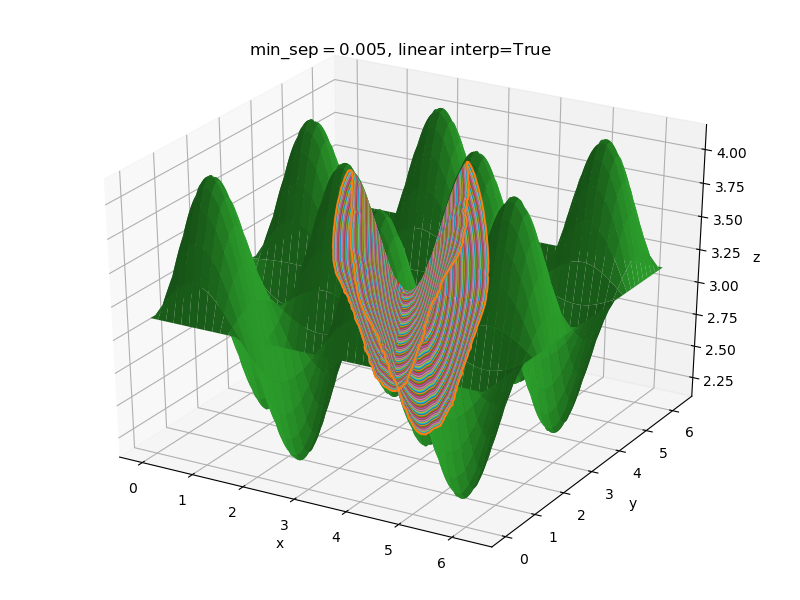

In [60]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

s = np.linspace(0,1,1000)

for l in mf2.levelsets[:]:
    pts = np.array([l.interpolation(s0) for s0 in s])
    ax.plot(pts[:,0], pts[:,1], pts[:,2])
    
if sinusoidalsurface:
    ax.plot_surface(np.meshgrid(x,y,indexing='ij')[0],np.meshgrid(x,y,indexing='ij')[1],np.pi+np.sin(2*np.meshgrid(x,y,indexing='ij')[0])*np.sin(2*np.meshgrid(x,y,indexing='ij')[1]))
#for l in mf.levelsets[20:40]:
#    for pts in l.points:
#        if (pts.in_AB):
#            col = 'r'
#        else:
#            col = 'k'
#        ax.scatter(pts.pos[0], pts.pos[1], pts.pos[2], c=col)
    

    
ax.set_title('min_sep$={}$, linear interp={}'.format(min_sep,True))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(np.pi-0.7,np.pi+0.7)
#ax.set_ylim(np.pi-0.7,np.pi+0.7)
#ax.set_zlim(np.pi-0.7,np.pi+0.7)
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#ax.set_zlim(zmin,zmax)



plt.tight_layout()

<IPython.core.display.Javascript object>


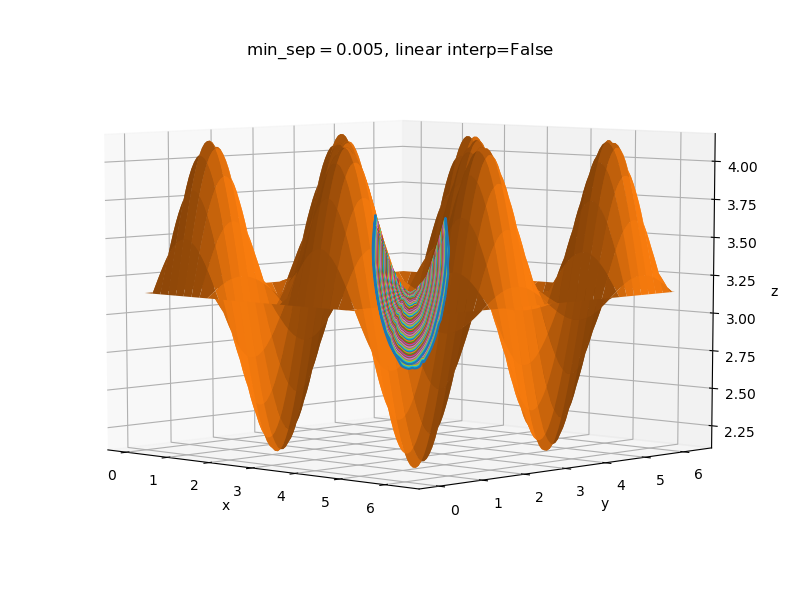

In [67]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

s = np.linspace(0,1,1000)

for l in mf.levelsets[:]:
    pts = np.array([l.interpolation(s0) for s0 in s])
    ax.plot(pts[:,0], pts[:,1], pts[:,2])
    
if sinusoidalsurface:
    ax.plot_surface(np.meshgrid(x,y,indexing='ij')[0],np.meshgrid(x,y,indexing='ij')[1],np.pi+np.sin(2*np.meshgrid(x,y,indexing='ij')[0])*np.sin(2*np.meshgrid(x,y,indexing='ij')[1]))
#for l in mf.levelsets[20:40]:
#    for pts in l.points:
#        if (pts.in_AB):
#            col = 'r'
#        else:
#            col = 'k'
#        ax.scatter(pts.pos[0], pts.pos[1], pts.pos[2], c=col)
    

    
ax.set_title('min_sep$={}$, linear interp={}'.format(min_sep,False))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(np.pi-0.7,np.pi+0.7)
#ax.set_ylim(np.pi-0.7,np.pi+0.7)
#ax.set_zlim(np.pi-0.7,np.pi+0.7)
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymax)
#ax.set_zlim(zmin,zmax)



plt.tight_layout()

In [139]:
np.allclose([p.pos for p in mf.levelsets[-1].points],[p.pos for p in mf2.levelsets[-1].points])

True

<IPython.core.display.Javascript object>


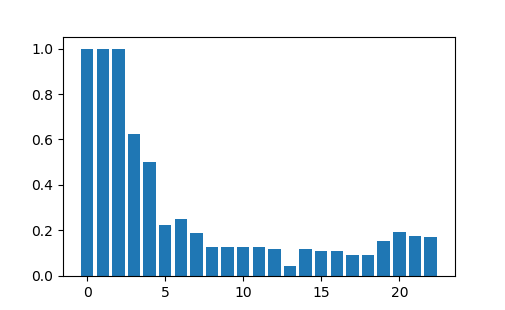

<Container object of 23 artists>

In [61]:
success_rate = []
for l in mf.levelsets: 
    success_rate.append(sum([int(pt.in_AB) for pt in l.points])/len(l.points))

plt.figure()
plt.bar(np.arange(0,len(mf.levelsets)), success_rate)


In [88]:
inABarr = []

for l in mf.levelsets: 
    inABarr.append([int(pt.in_AB) for pt in l.points])

In [197]:
init_pos = np.array([x[44],y[50],z[50]]) #<= E.g. for ABC flow
#init_pos = np.array([x[50],y[50],z[54]]) #<= E.g. for ABC flow
#init_pos = np.array([x[27],y[34],z[85]]) #<= E.g. for ABC flow
#init_pos = np.array([x[6],y[5],z[54]]) #<= E.g. for ABC flow
#init_pos = np.array([0,1,0]) # <= E.g. for spherical shell
#init_pos = np.array([2.11,3.11,4.11])
dom_bound = np.array([0,2*np.pi,0,2*np.pi,0,2*np.pi])
max_geo_dist = 2
min_s_step = 0.0001
max_s_step = 0.01
dist_tol = 0.005
plane_tol = 0.005
tan_tol = 0.1
min_ang = 1
max_ang = 2
min_sep = 0.005
max_sep = 0.04
dist = min_sep*2
min_dist_ang = min_ang*min_sep*2
max_dist_ang = max_ang*min_sep*2

mf2 = (Manifold(init_pos,dom_bound,max_geo_dist,min_s_step,max_s_step,dist,dist_tol,plane_tol,tan_tol,
                      min_ang,max_ang,min_dist_ang,max_dist_ang,min_sep,max_sep))

In [198]:
t = time.time()
mf2.add_level_sets(1000)
print(time.time()-t)
print(mf.geo_dist)

Number of points in first geodesic level: 8
Level set 2 done -> Points: 8 Geodesic distance=0.010 ,Time=0.00 seconds
Level set 3 done -> Points: 8 Geodesic distance=0.020 ,Time=0.03 seconds
Level set 4 done -> Points: 8 Geodesic distance=0.030 ,Time=0.19 seconds
Level set 5 done -> Points: 8 Geodesic distance=0.040 ,Time=0.09 seconds
Level set 6 done -> Points: 10 Geodesic distance=0.050 ,Time=0.02 seconds
Level set 7 done -> Points: 16 Geodesic distance=0.060 ,Time=0.05 seconds
Level set 8 done -> Points: 16 Geodesic distance=0.070 ,Time=0.01 seconds
Level set 9 done -> Points: 16 Geodesic distance=0.080 ,Time=0.02 seconds
Level set 10 done -> Points: 16 Geodesic distance=0.090 ,Time=0.03 seconds
Level set 11 done -> Points: 18 Geodesic distance=0.100 ,Time=0.03 seconds
Level set 12 done -> Points: 32 Geodesic distance=0.110 ,Time=0.10 seconds
Level set 13 done -> Points: 32 Geodesic distance=0.120 ,Time=0.10 seconds
Level set 14 done -> Points: 32 Geodesic distance=0.130 ,Time=0.07 s

Smaller step than min_sep required with current requirements. Continuing anyway
Returned VERY ass point after throwing shit at wall
Level set 95 done -> Points: 283 Geodesic distance=0.785 ,Time=13.69 seconds
Smaller step than min_sep required with current requirements. Continuing anyway
Level set 96 done -> Points: 290 Geodesic distance=0.790 ,Time=13.16 seconds
Level set 97 done -> Points: 295 Geodesic distance=0.795 ,Time=14.01 seconds
Level set 98 done -> Points: 302 Geodesic distance=0.800 ,Time=11.45 seconds
Smaller step than min_sep required with current requirements. Continuing anyway
Level set 99 done -> Points: 311 Geodesic distance=0.805 ,Time=11.37 seconds
Level set 100 done -> Points: 316 Geodesic distance=0.810 ,Time=13.61 seconds
Smaller step than min_sep required with current requirements. Continuing anyway
Level set 101 done -> Points: 323 Geodesic distance=0.815 ,Time=16.63 seconds
Smaller step than min_sep required with current requirements. Continuing anyway
Level s

<IPython.core.display.Javascript object>


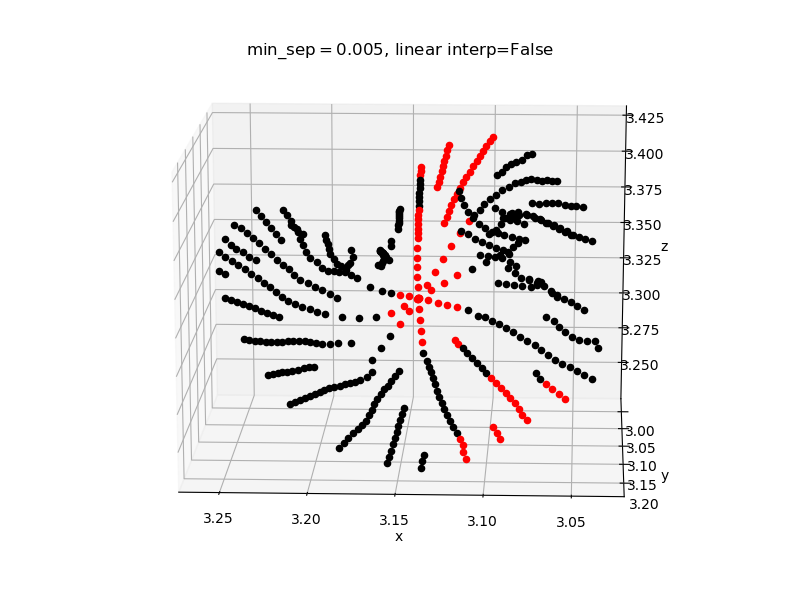

In [63]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

s = np.linspace(0,1,1000)

#for l in mf2.levelsets:
#    pts = np.array([l.interpolation(s0) for s0 in s])
#    ax.plot(pts[:,0], pts[:,1], pts[:,2])
    
for l in mf.levelsets:
    for pts in l.points:
        if (pts.in_AB):
            col = 'r'
        else:
            col = 'k'
        ax.scatter(pts.pos[0], pts.pos[1], pts.pos[2], c=col)
    

    
ax.set_title('min_sep$={}$, linear interp={}'.format(min_sep,linear_itp))

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(xmin,xmax)
#ax.set_ylim(ymin,ymaz)
#ax.set_zlim(zmin,zmax)



plt.tight_layout()

In [ ]:
def comp_msk_d():
    mask_d = np.empty((nx,ny,nz),dtype=np.bool)
    innerprod = np.empty((nx,ny,nz))
    for k in range(nz):
        for j in range(ny):
            for i in range(nx):
                innerprod[i,j,k] = lm3_itp.grad(np.array([x[i],y[j],z[k]])).dot(xi3_itp(np.array([x[i],y[j],z[k]])))
    for k in range(nz):
        for j in range(ny):
            for i in range(nx):
                dps = [innerprod[np.divmod(i-1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j-1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k-1,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i-1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k+1,nz)[1]],
                       innerprod[np.divmod(i,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                       innerprod[np.divmod(i+1,nx)[1],np.divmod(j+1,ny)[1],np.divmod(k,nz)[1]],
                      ]
                mask_d[i,j,k] = np.any(np.less_equal([d*dps[0] for d in dps],0))
    return mask_d

In [44]:
poss = np.array([p.pos for p in mf.levelsets[-1].points])

In [64]:
nm = 6
dist0 = np.linalg.norm(poss[nm]-poss,axis=1)

In [65]:
#dist0

<IPython.core.display.Javascript object>


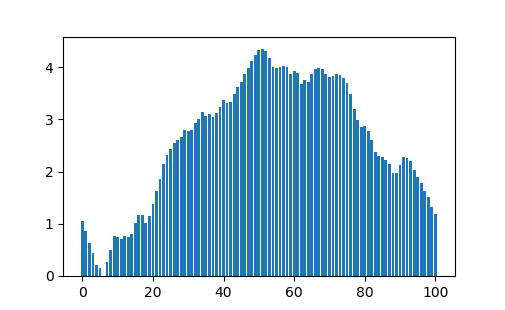

<Container object of 101 artists>

In [66]:
plt.figure()
plt.bar(np.arange(len(poss)),dist0)

In [68]:
np.linalg.norm(poss,axis=1).shape

(101,)

In [74]:
ql = [i for i in range(4)]

In [66]:
ql

[0, 1, 2, 3]

In [67]:
msk = np.empty(4,dtype=np.bool)

In [68]:
msk

array([False, False, False, False])

In [69]:
msk[1:3] = True

In [70]:
msk

array([False,  True,  True, False])

In [71]:
ql[msk]

TypeError: only integer scalar arrays can be converted to a scalar index

In [72]:
ql = np.asarray(ql)

In [73]:
ql[msk]

array([1, 2])

In [80]:
def bar():
    q2 = list(np.asarray(ql)[msk])

In [81]:
def foo():
    q3 = []
    for ind, tf in enumerate(msk):
        if tf: 
            q3.append(ql[ind])

In [82]:
%timeit foo()

1.79 µs ± 67.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [83]:
%timeit bar()

4.64 µs ± 61.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [84]:
np.sum(msk)

2